# Base Models
In this notebook, we'll build some base models with PyMC. 
We start with an intercept-only model (basically estimating the mean) and then extend this to a linear model.
For both models we try some different likelihoods, namely a normal likelihood as well as a Student-T likelihood (robust model).

In [1]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

import arviz as az

from utils.data_utils import destandardize_area, destandardize_price, load_data, standardize_area
from utils.plot_utils import set_plot_defaults

/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
d, _, _ = load_data(kind="prices")
set_plot_defaults("Europace Sans")
target = "price_s"

In [3]:
d.drop(columns=["lat", "lng"]).head()

,ags,zip,price,price_s,log_price,log_price_s,sqm_price,log_sqm_price,log_sqm_price_s,living_space,living_space_s,sale_year,sale_month,const_year,const_year_s,objecttype,housetype,usage,interior_qual,zip_code
3,11000000001000000094,12489,180000.0,1.800,12.100712,-0.814839,2246.069379,7.716937,-1.009445,80.14,-0.276690,2018,8,1936.0,-1.210219,flat,NaN,rent_out,normal,117
4,11000000001000000094,12489,87000.0,0.870,11.373663,-2.045434,1740.000000,7.461640,-1.700113,50.00,-0.671528,2017,7,1910.0,-1.913696,flat,NaN,rent_out,NaN,117
6,11000000001000000140,12489,101200.0,1.012,11.524854,-1.789530,3066.666667,8.028346,-0.166971,33.00,-0.894229,2016,4,2016.0,0.954326,flat,NaN,rent_out,NaN,117
9,11000000001000000140,12489,148400.0,1.484,11.907667,-1.141586,3420.142890,8.137438,0.128159,43.39,-0.758119,2017,1,2017.0,0.981383,flat,NaN,rent_out,sophisticated,117
10,11000000001000000140,12489,261200.0,2.612,12.473042,-0.184638,3374.677003,8.124055,0.091954,77.40,-0.312584,2016,6,2016.0,0.954326,flat,NaN,rent_out,sophisticated,117


## Intercept only model

$$\begin{align*}
price &\sim \text{Normal}(\mu, \sigma)\\
\mu &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{HalfNormal}(10)
\end{align*}$$

I'm also trying out different priors for $\sigma$. If you want to know more about which priors are recommended for which kind of model, check this [prior recommendation](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) by the Stan team.

In [5]:
with pm.Model() as intercept_normal:
    mu = pm.Normal("mu", mu=0, sd=10)
    sigma = pm.HalfNormal("sigma", sd=10)
    
    y = pm.Normal("y", mu=mu, sd=sigma, observed = d[target])
    
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:15<00:00, 509.15draws/s]


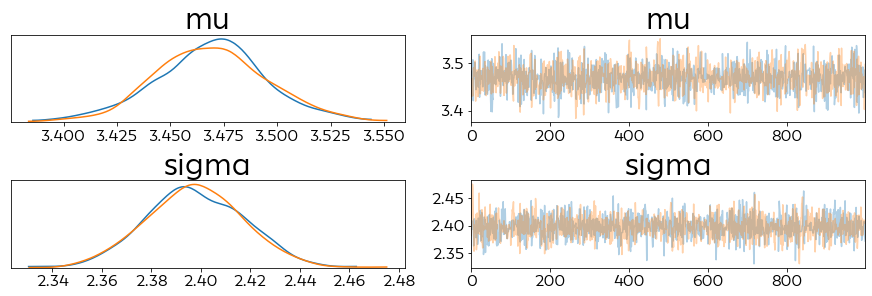

In [6]:
az.plot_trace(trace, coords={"chain":[0,1]})
plt.show()

The robust version of this model uses  Student-T likelihood instead:
$$\begin{align*}
price &\sim \text{Student-T}(\mu, \sigma, \nu)\\
\mu &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{HalfCauchy}(10)\\
\nu &\sim \text{Gamma}(\alpha=2, \beta=0.1)
\end{align*}$$

In [7]:
with pm.Model() as intercept_student:
    mu = pm.Normal("mu", mu=0, sd=20)
    sigma = pm.HalfCauchy("sigma", 10)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    
    y = pm.StudentT("y", mu=mu, sd=sigma, nu=nu, observed=d[target])
    
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [nu, sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:32<00:00, 242.69draws/s]


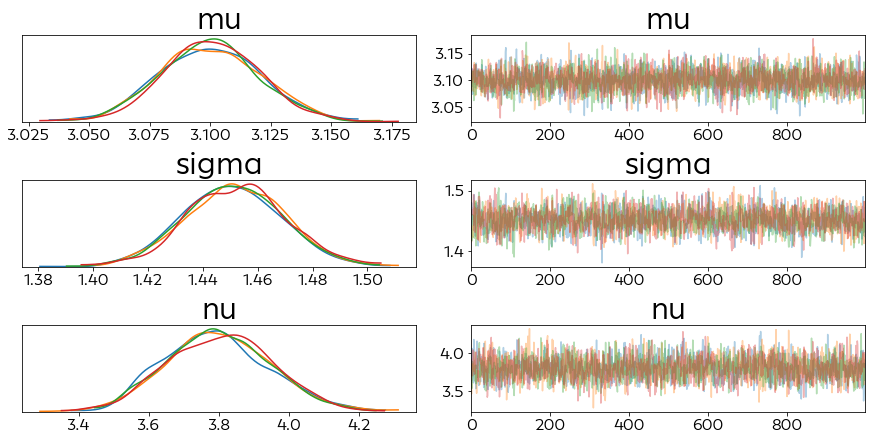

In [8]:
az.plot_trace(trace)
plt.show()

## Linear base model
We add the predictor of the living area to the model. Note that the living area is standardized, so that the intercept represents the price for an average-sized home (which is 101sqm).

$$\begin{align*}
price &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha + \beta \;\text{living_space}\\
\alpha &\sim \text{Normal}(0, 10) \\
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1/5)
\end{align*}$$

In [9]:
with pm.Model() as lin_normal:
    living_space = pm.Data("living_space", d["living_space_s"])
    
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=1)
    mu = alpha + beta*living_space
    
    sigma = pm.Exponential("sigma", 1/5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d["price_s"])
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:20<00:00, 393.26draws/s]


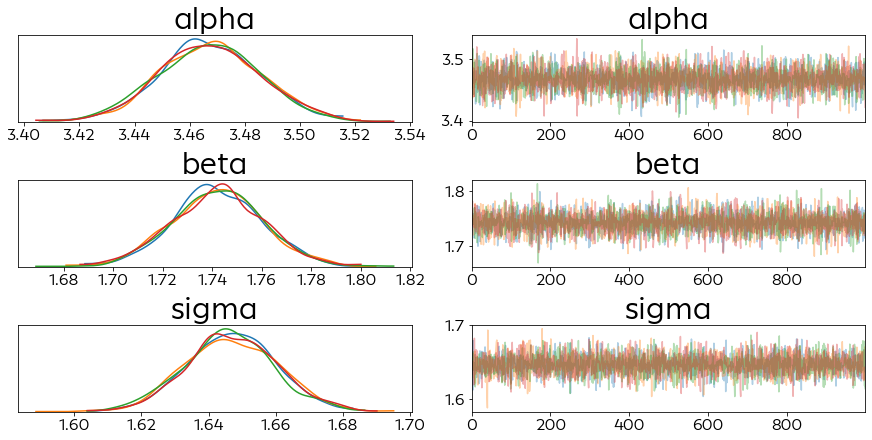

In [10]:
az.plot_trace(trace)
plt.show()

We can do the same with a Student likelihood:

In [11]:
with pm.Model() as lin_student:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=1)
    mu = alpha + beta*d["living_space_s"]
    
    sigma = pm.HalfCauchy("sigma", 5)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    y = pm.StudentT("y", nu=nu, mu=mu, sd=sigma, observed=d[target])
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    
    prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [nu, sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:37<00:00, 212.33draws/s]


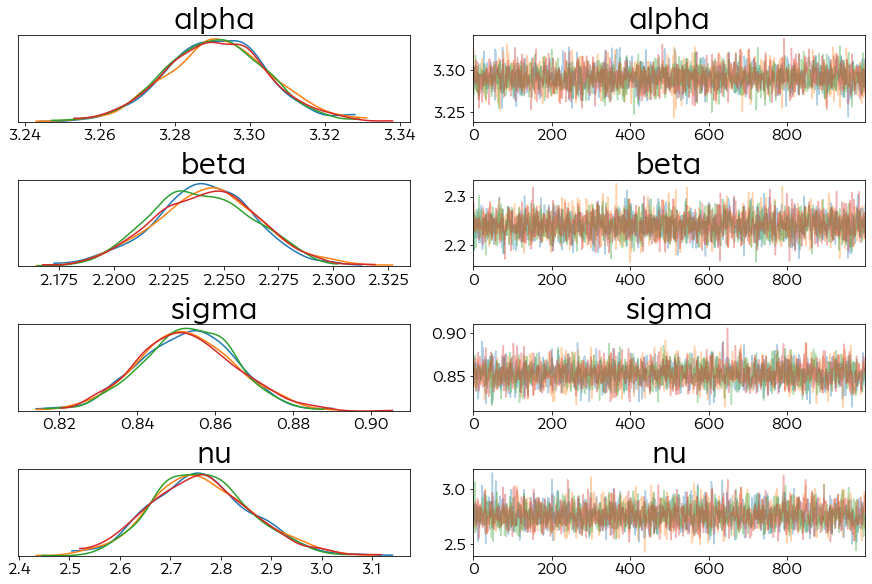

In [12]:
az.plot_trace(trace)
plt.show()